# Solution Part:
* Data Understanding
* Data Exploration
* Data Cleaning
* Data Preparation/Feature Engineering
* Model Building
* Model Evaluation

In [120]:
#Import all the libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)

In [121]:
import warnings
warnings.filterwarnings('ignore')

In [122]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [123]:
pd.set_option('display.max_rows', None)

In [124]:
#Read the dataset
cars = pd.read_parquet('Customer Database.parquet')
cars_test = pd.read_excel('Test Customer Data.xlsx')
cars_test_original = cars_test.copy()

In [125]:
cars.shape

(3519243, 34)

In [126]:
cars.head()

,Location_Region,VRLOCATION,VRSALEAMT,VRMILEAGE,Vehicle_year,Trim,Series,Vehicle_cylinders,Vehicle_botcolor,Vehicle_doors,Vehicle_trantype,Vehicle_engine,Vehicle_drive,Vehicle_condition_drivable,Vehicle_condition_overall,BodyClass,DriveType,EngineHP,FuelTypePrimary,EngineConfiguration,EngineModel,GVWR,PlantCountry,BasePrice,IsEV,EVType,MarketSegment,SALEDATE_WeekofYearNumber,SALEDATE_MonthofYearNumber,SALEDATE_Quarter,SALEDATE_Year,Model,Make,VRSALEDATE
0,SOUTH,GREENVILLE,4800,161231,2015.0,None,ZVW30L,4.0,GRN,4.0,A,1.8,F,Y,2.0,Hatchback/Liftback/Notchback,4x2,NaN,Gasoline,In-Line,2ZR-FXE+3JM,"Class 1: 6,000 lb or less (2,722 kg or less)",JAPAN,None,1,Hybrid,EV Hatchback,37,9,3,2025,Prius,TOYOTA,20250912
1,WEST,DALLAS,3500,244732,2014.0,Touring/Touring-EL,None,6.0,SIL,4.0,A,3.5,F,None,NaN,Minivan,None,248.0,Gasoline,V-Shaped,J35Z8,"Class 2E: 6,001 - 7,000 lb (2,722 - 3,175 kg)",UNITED STATES (USA),None,0,ICE,Minivan,14,4,2,2025,Odyssey,HONDA,20250401
2,EAST,CHARLESTON,15500,92087,2019.0,Standard,None,4.0,GRY,4.0,A,2.4,F,None,NaN,Sedan/Saloon,4x2,206.0,Gasoline,In-Line,K24W7,"Class 1C: 4,001 - 5,000 lb (1,814 - 2,268 kg)",UNITED STATES (USA),None,0,ICE,Sedan,11,3,1,2025,TLX,ACURA,20250314
3,EAST,CHARLESTON,19600,46553,2021.0,None,SEL FHEV,4.0,WHT,4.0,A,2.5,F,Y,5.0,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,4x2,NaN,Gasoline,In-Line,HEV/PHEV,"Class 1C: 4,001 - 5,000 lb (1,814 - 2,268 kg)",UNITED STATES (USA),None,1,Hybrid,EV SUV,13,3,1,2025,Escape,FORD,20250328
4,NORTH,BADGERSTATE,10000,114800,2017.0,Platinum,None,6.0,BLK,4.0,A,3.5,4,Y,NaN,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,4WD/4-Wheel Drive/4x4,365.0,Gasoline,V-Shaped,3.5L GTDI,"Class 2E: 6,001 - 7,000 lb (2,722 - 3,175 kg)",UNITED STATES (USA),53235.00,0,ICE,SUV 3-Row,5,2,1,2025,Explorer,FORD,20250130


Data Exploration

In [127]:
def clean_and_fix_temporal(df):
    df = df.copy()

    # --- sale_date (approx from Year+Month if you have them) ---
    # If you also have day, use it. Otherwise pivot to middle-of-month.
    df["SALEDATE_Year"] = pd.to_numeric(df["SALEDATE_Year"], errors="coerce")
    df["SALEDATE_MonthofYearNumber"] = pd.to_numeric(df["SALEDATE_MonthofYearNumber"], errors="coerce").fillna(6)
    df["sale_date"] = pd.to_numeric(df["VRSALEDATE"], errors="coerce")
    df['IsEV'] = pd.to_numeric(df["IsEV"])


    # --- Vehicle condition grade: extract number safely ---
    # Works for "Grade 3.5", "3.5", 0.0, etc.
    if "Vehicle_condition_overall" in df.columns:
        vc = df["Vehicle_condition_overall"].astype(str).str.extract(r'(\d+(\.\d+)?)')[0]
        df["Vehicle_condition_overall"] = pd.to_numeric(vc, errors="coerce")

    # --- Numeric coercions you rely on downstream ---
    num_cols = [
        'VRSALEAMT','VRMILEAGE','Vehicle_year','Vehicle_cylinders','Vehicle_doors',
        'Vehicle_engine','Vehicle_condition_overall','EngineHP','BasePrice',
        'SALEDATE_WeekofYearNumber','SALEDATE_MonthofYearNumber','SALEDATE_Quarter',
        'SALEDATE_Year','vehicle_age','mileage_per_year','log_mileage','log_age',
        'drivable_flag','GVWR_class'
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # --- clamp & age at sale ---
    df["Vehicle_year"] = df["Vehicle_year"].clip(1900, 2100)
    df["vehicle_age"] = (df["SALEDATE_Year"] - df["Vehicle_year"]).clip(lower=0)

    # --- mileage hygiene ---
    # cap ridiculous mileage and fix negatives
    df["VRMILEAGE"] = df["VRMILEAGE"].clip(lower=0, upper=df["VRMILEAGE"].quantile(0.9995))

    # --- safe ratios/logs ---
    age_safe = df["vehicle_age"].replace(0, 0.5)
    df["mileage_per_year"] = df["VRMILEAGE"] / age_safe
    df["log_mileage"] = np.log1p(df["VRMILEAGE"])
    df["log_age"] = np.log1p(df["vehicle_age"])

    # --- drivable ---
    df["drivable_flag"] = (df["Vehicle_condition_drivable"] == "Y").astype(np.int8)

    # --- GVWR numeric class extraction (keeps signal, shrinks OHE) ---
    # "Class 1: 6,000 lb..." -> 1
    if "GVWR" in df.columns:
        df["GVWR_class"] = (
            df["GVWR"].astype(str).str.extract(r'Class\s*(\d+)')[0].astype(float)
        )

    # downcast numerics
    for c in df.select_dtypes(include=[np.number]).columns:
        df[c] = pd.to_numeric(df[c], downcast="float")

    return df

In [128]:
cars = clean_and_fix_temporal(cars)
cars_test = clean_and_fix_temporal(cars_test)

In [129]:
cars.dtypes

Location_Region                object
VRLOCATION                     object
VRSALEAMT                     float32
VRMILEAGE                     float64
Vehicle_year                  float32
Trim                           object
Series                         object
Vehicle_cylinders             float32
Vehicle_botcolor               object
Vehicle_doors                 float32
Vehicle_trantype               object
Vehicle_engine                float32
Vehicle_drive                  object
Vehicle_condition_drivable     object
Vehicle_condition_overall     float32
BodyClass                      object
DriveType                      object
EngineHP                      float32
FuelTypePrimary                object
EngineConfiguration            object
EngineModel                    object
GVWR                           object
PlantCountry                   object
BasePrice                     float32
IsEV                          float32
EVType                         object
MarketSegmen

In [130]:
cars.head()

,Location_Region,VRLOCATION,VRSALEAMT,VRMILEAGE,Vehicle_year,Trim,Series,Vehicle_cylinders,Vehicle_botcolor,Vehicle_doors,Vehicle_trantype,Vehicle_engine,Vehicle_drive,Vehicle_condition_drivable,Vehicle_condition_overall,BodyClass,DriveType,EngineHP,FuelTypePrimary,EngineConfiguration,EngineModel,GVWR,PlantCountry,BasePrice,IsEV,EVType,MarketSegment,SALEDATE_WeekofYearNumber,SALEDATE_MonthofYearNumber,SALEDATE_Quarter,SALEDATE_Year,Model,Make,VRSALEDATE,sale_date,vehicle_age,mileage_per_year,log_mileage,log_age,drivable_flag,GVWR_class
0,SOUTH,GREENVILLE,4800.0,161231.0,2015.0,None,ZVW30L,4.0,GRN,4.0,A,1.8,F,Y,2.0,Hatchback/Liftback/Notchback,4x2,NaN,Gasoline,In-Line,2ZR-FXE+3JM,"Class 1: 6,000 lb or less (2,722 kg or less)",JAPAN,NaN,1.0,Hybrid,EV Hatchback,37.0,9.0,3.0,2025.0,Prius,TOYOTA,20250912,20250912.0,10.0,16123.100000,11.990600,2.397895,1,1.0
1,WEST,DALLAS,3500.0,244732.0,2014.0,Touring/Touring-EL,None,6.0,SIL,4.0,A,3.5,F,None,NaN,Minivan,None,248.0,Gasoline,V-Shaped,J35Z8,"Class 2E: 6,001 - 7,000 lb (2,722 - 3,175 kg)",UNITED STATES (USA),NaN,0.0,ICE,Minivan,14.0,4.0,2.0,2025.0,Odyssey,HONDA,20250401,20250401.0,11.0,22248.363636,12.407923,2.484907,0,2.0
2,EAST,CHARLESTON,15500.0,92087.0,2019.0,Standard,None,4.0,GRY,4.0,A,2.4,F,None,NaN,Sedan/Saloon,4x2,206.0,Gasoline,In-Line,K24W7,"Class 1C: 4,001 - 5,000 lb (1,814 - 2,268 kg)",UNITED STATES (USA),NaN,0.0,ICE,Sedan,11.0,3.0,1.0,2025.0,TLX,ACURA,20250314,20250314.0,6.0,15347.833333,11.430500,1.945910,0,1.0
3,EAST,CHARLESTON,19600.0,46553.0,2021.0,None,SEL FHEV,4.0,WHT,4.0,A,2.5,F,Y,5.0,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,4x2,NaN,Gasoline,In-Line,HEV/PHEV,"Class 1C: 4,001 - 5,000 lb (1,814 - 2,268 kg)",UNITED STATES (USA),NaN,1.0,Hybrid,EV SUV,13.0,3.0,1.0,2025.0,Escape,FORD,20250328,20250328.0,4.0,11638.250000,10.748368,1.609438,1,1.0
4,NORTH,BADGERSTATE,10000.0,114800.0,2017.0,Platinum,None,6.0,BLK,4.0,A,3.5,4,Y,NaN,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,4WD/4-Wheel Drive/4x4,365.0,Gasoline,V-Shaped,3.5L GTDI,"Class 2E: 6,001 - 7,000 lb (2,722 - 3,175 kg)",UNITED STATES (USA),53235.0,0.0,ICE,SUV 3-Row,5.0,2.0,1.0,2025.0,Explorer,FORD,20250130,20250130.0,8.0,14350.000000,11.650955,2.197225,1,2.0


In [131]:
cars_numeric = cars.select_dtypes(include=[np.number])

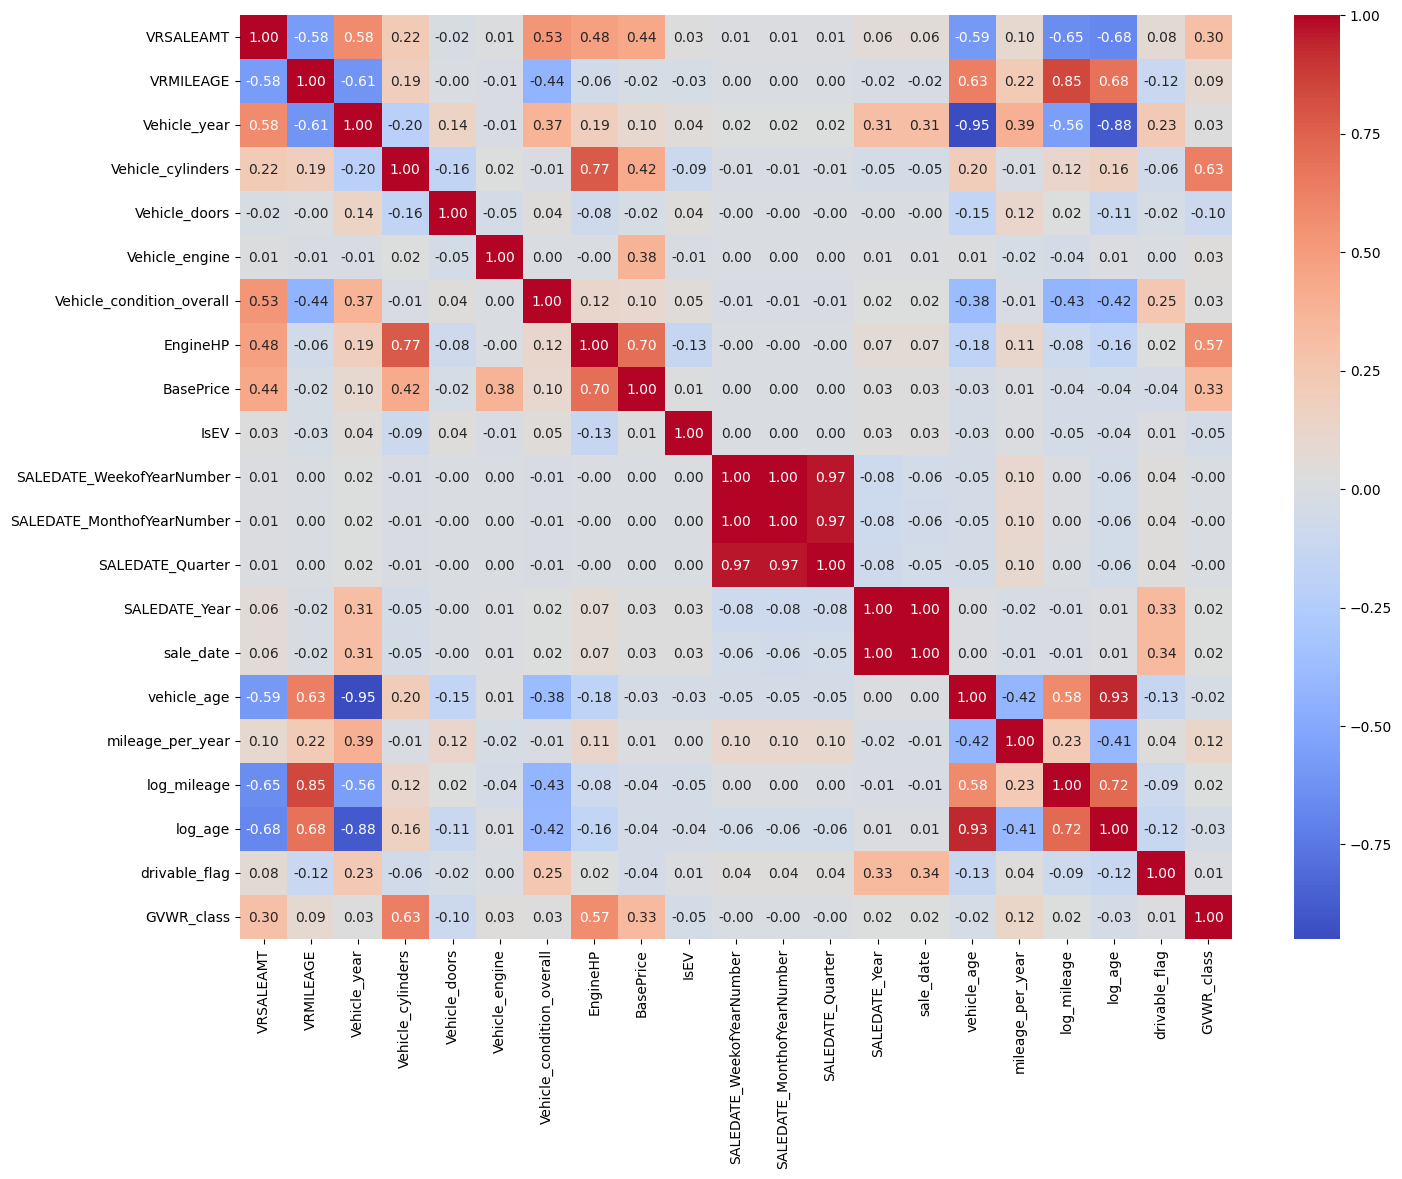

In [132]:
plt.figure(figsize=(16, 12))
sns.heatmap(cars_numeric.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [133]:
#Correlation plot
cor = cars_numeric.corr()
cor

,VRSALEAMT,VRMILEAGE,Vehicle_year,Vehicle_cylinders,Vehicle_doors,Vehicle_engine,Vehicle_condition_overall,EngineHP,BasePrice,IsEV,SALEDATE_WeekofYearNumber,SALEDATE_MonthofYearNumber,SALEDATE_Quarter,SALEDATE_Year,sale_date,vehicle_age,mileage_per_year,log_mileage,log_age,drivable_flag,GVWR_class
VRSALEAMT,1.000000,-0.575154,0.580099,0.223057,-0.016534,0.011347,0.528147,0.478525,0.439989,0.032762,0.006207,0.006160,0.005933,0.055974,0.055849,-0.591494,0.098963,-0.646809,-0.681167,0.075041,0.298335
VRMILEAGE,-0.575154,1.000000,-0.606833,0.188696,-0.002800,-0.012601,-0.439066,-0.060583,-0.024057,-0.026767,0.001141,0.001273,0.000954,-0.016931,-0.016910,0.632584,0.220918,0.845345,0.680517,-0.117388,0.088122
Vehicle_year,0.580099,-0.606833,1.000000,-0.203709,0.142593,-0.007496,0.369617,0.191726,0.099899,0.041986,0.019616,0.019246,0.019960,0.309675,0.310397,-0.949447,0.391594,-0.557894,-0.884067,0.231795,0.027728
Vehicle_cylinders,0.223057,0.188696,-0.203709,1.000000,-0.161944,0.022469,-0.010838,0.772800,0.424008,-0.091227,-0.008065,-0.008011,-0.008027,-0.050104,-0.050339,0.197699,-0.006879,0.124040,0.162674,-0.061403,0.629853
Vehicle_doors,-0.016534,-0.002800,0.142593,-0.161944,1.000000,-0.046751,0.039400,-0.077987,-0.021356,0.040288,-0.001745,-0.001599,-0.001705,-0.002044,-0.002091,-0.150867,0.120108,0.023908,-0.109704,-0.021602,-0.100305
Vehicle_engine,0.011347,-0.012601,-0.007496,0.022469,-0.046751,1.000000,0.001649,-0.004585,0.380202,-0.007230,0.000095,0.000182,0.000678,0.009117,0.009125,0.010893,-0.021693,-0.036746,0.007874,0.001613,0.034404
Vehicle_condition_overall,0.528147,-0.439066,0.369617,-0.010838,0.039400,0.001649,1.000000,0.115638,0.104556,0.045232,-0.011872,-0.011612,-0.011499,0.018726,0.018417,-0.381738,-0.007446,-0.427422,-0.415578,0.246847,0.032318
EngineHP,0.478525,-0.060583,0.191726,0.772800,-0.077987,-0.004585,0.115638,1.000000,0.702804,-0.128081,-0.001090,-0.001106,-0.000983,0.069466,0.069472,-0.179380,0.112230,-0.083639,-0.156343,0.023699,0.569759
BasePrice,0.439989,-0.024057,0.099899,0.424008,-0.021356,0.380202,0.104556,0.702804,1.000000,0.012348,0.000309,0.000441,0.000714,0.031982,0.032006,-0.034046,0.008636,-0.037874,-0.043260,-0.040913,0.334297
IsEV,0.032762,-0.026767,0.041986,-0.091227,0.040288,-0.007230,0.045232,-0.128081,0.012348,1.000000,0.000949,0.000915,0.001221,0.031966,0.032073,-0.033587,0.004182,-0.046370,-0.040863,0.009170,-0.047934


In [134]:
cars.isnull().sum()

Location_Region                     0
VRLOCATION                          0
VRSALEAMT                           0
VRMILEAGE                           0
Vehicle_year                        1
Trim                          1159477
Series                        2071744
Vehicle_cylinders               59218
Vehicle_botcolor               552128
Vehicle_doors                  101221
Vehicle_trantype               427059
Vehicle_engine                   8703
Vehicle_drive                  433264
Vehicle_condition_drivable    1438289
Vehicle_condition_overall     1987796
BodyClass                         307
DriveType                      932299
EngineHP                      1855340
FuelTypePrimary                 97132
EngineConfiguration           1316529
EngineModel                   1565157
GVWR                             9047
PlantCountry                     1948
BasePrice                     3046200
IsEV                                0
EVType                              0
MarketSegmen

Data Preparation

In [135]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute   import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error

In [136]:
cars.head()

,Location_Region,VRLOCATION,VRSALEAMT,VRMILEAGE,Vehicle_year,Trim,Series,Vehicle_cylinders,Vehicle_botcolor,Vehicle_doors,Vehicle_trantype,Vehicle_engine,Vehicle_drive,Vehicle_condition_drivable,Vehicle_condition_overall,BodyClass,DriveType,EngineHP,FuelTypePrimary,EngineConfiguration,EngineModel,GVWR,PlantCountry,BasePrice,IsEV,EVType,MarketSegment,SALEDATE_WeekofYearNumber,SALEDATE_MonthofYearNumber,SALEDATE_Quarter,SALEDATE_Year,Model,Make,VRSALEDATE,sale_date,vehicle_age,mileage_per_year,log_mileage,log_age,drivable_flag,GVWR_class
0,SOUTH,GREENVILLE,4800.0,161231.0,2015.0,None,ZVW30L,4.0,GRN,4.0,A,1.8,F,Y,2.0,Hatchback/Liftback/Notchback,4x2,NaN,Gasoline,In-Line,2ZR-FXE+3JM,"Class 1: 6,000 lb or less (2,722 kg or less)",JAPAN,NaN,1.0,Hybrid,EV Hatchback,37.0,9.0,3.0,2025.0,Prius,TOYOTA,20250912,20250912.0,10.0,16123.100000,11.990600,2.397895,1,1.0
1,WEST,DALLAS,3500.0,244732.0,2014.0,Touring/Touring-EL,None,6.0,SIL,4.0,A,3.5,F,None,NaN,Minivan,None,248.0,Gasoline,V-Shaped,J35Z8,"Class 2E: 6,001 - 7,000 lb (2,722 - 3,175 kg)",UNITED STATES (USA),NaN,0.0,ICE,Minivan,14.0,4.0,2.0,2025.0,Odyssey,HONDA,20250401,20250401.0,11.0,22248.363636,12.407923,2.484907,0,2.0
2,EAST,CHARLESTON,15500.0,92087.0,2019.0,Standard,None,4.0,GRY,4.0,A,2.4,F,None,NaN,Sedan/Saloon,4x2,206.0,Gasoline,In-Line,K24W7,"Class 1C: 4,001 - 5,000 lb (1,814 - 2,268 kg)",UNITED STATES (USA),NaN,0.0,ICE,Sedan,11.0,3.0,1.0,2025.0,TLX,ACURA,20250314,20250314.0,6.0,15347.833333,11.430500,1.945910,0,1.0
3,EAST,CHARLESTON,19600.0,46553.0,2021.0,None,SEL FHEV,4.0,WHT,4.0,A,2.5,F,Y,5.0,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,4x2,NaN,Gasoline,In-Line,HEV/PHEV,"Class 1C: 4,001 - 5,000 lb (1,814 - 2,268 kg)",UNITED STATES (USA),NaN,1.0,Hybrid,EV SUV,13.0,3.0,1.0,2025.0,Escape,FORD,20250328,20250328.0,4.0,11638.250000,10.748368,1.609438,1,1.0
4,NORTH,BADGERSTATE,10000.0,114800.0,2017.0,Platinum,None,6.0,BLK,4.0,A,3.5,4,Y,NaN,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,4WD/4-Wheel Drive/4x4,365.0,Gasoline,V-Shaped,3.5L GTDI,"Class 2E: 6,001 - 7,000 lb (2,722 - 3,175 kg)",UNITED STATES (USA),53235.0,0.0,ICE,SUV 3-Row,5.0,2.0,1.0,2025.0,Explorer,FORD,20250130,20250130.0,8.0,14350.000000,11.650955,2.197225,1,2.0


In [137]:
categorical_cols = cars.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical:", categorical_cols)

Categorical: ['Location_Region', 'VRLOCATION', 'Trim', 'Series', 'Vehicle_botcolor', 'Vehicle_trantype', 'Vehicle_drive', 'Vehicle_condition_drivable', 'BodyClass', 'DriveType', 'FuelTypePrimary', 'EngineConfiguration', 'EngineModel', 'GVWR', 'PlantCountry', 'EVType', 'MarketSegment', 'Model', 'Make', 'VRSALEDATE']


In [ ]:
# remove engine from your list of categoricals...
categorical_feats = [
    'Location_Region', 'VRLOCATION', 'Trim', 'Series', 'Vehicle_botcolor', 'Vehicle_trantype', 'Vehicle_drive', 
    'Vehicle_condition_drivable', 'BodyClass', 'DriveType', 'FuelTypePrimary', 'EngineConfiguration', 'EngineModel', 
    'GVWR', 'PlantCountry', 'IsEV', 'EVType', 'MarketSegment', 'Model', 'Make'
]
# …and add it into numeric_feats
numeric_feats = [
    'VRSALEAMT','VRMILEAGE','Vehicle_year','Vehicle_cylinders','Vehicle_doors','Vehicle_engine',
    'Vehicle_condition_overall','EngineHP','BasePrice','SALEDATE_WeekofYearNumber','SALEDATE_MonthofYearNumber',
    'SALEDATE_Quarter','SALEDATE_Year','vehicle_age','mileage_per_year','log_mileage','log_age',
    'drivable_flag','GVWR_class','sale_date'
]


In [139]:
from scipy.stats import skew
skewness = skew(cars['Vehicle_condition_overall'].dropna())
print("Skewness:", skewness)

Skewness: -0.31964969635009766


In [140]:
X_external = cars_test[numeric_feats + categorical_feats]

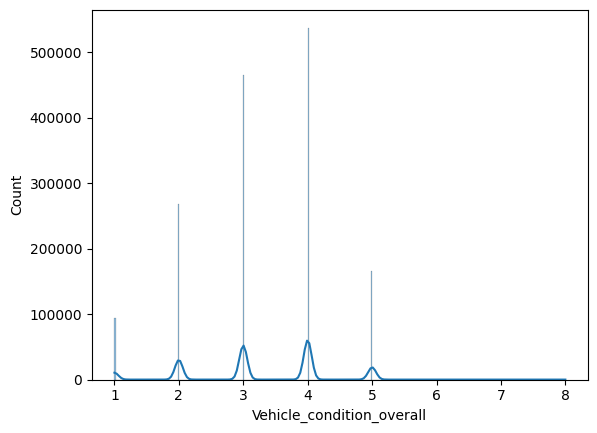

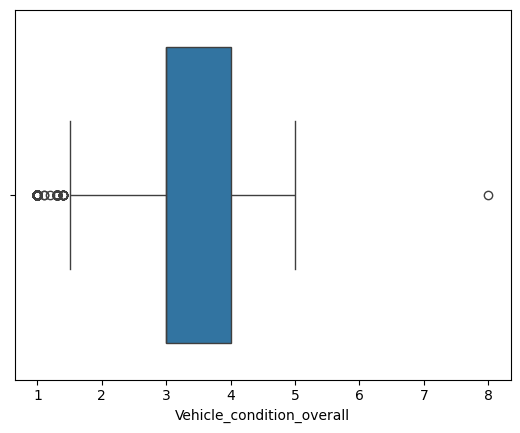

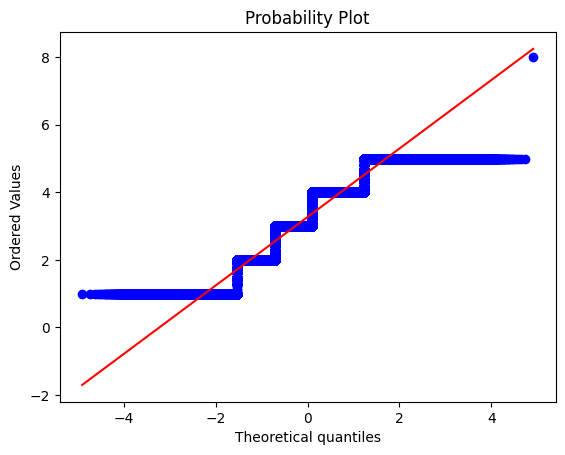

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.histplot(cars['Vehicle_condition_overall'], kde=True)
plt.show()

sns.boxplot(x=cars['Vehicle_condition_overall'])
plt.show()

stats.probplot(cars['Vehicle_condition_overall'].dropna(), dist="norm", plot=plt)
plt.show()

In [142]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale',   StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown', add_indicator=True)),
    ('ohe',      OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_feats),
    ('cat', cat_pipe, categorical_feats),
], remainder='drop', sparse_threshold=1.0)

In [143]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [144]:
# Sort by time to avoid leakage
cars = cars.dropna(subset=["sale_date"]).sort_values("sale_date")

# Keep the last 10% of time as your validation/test set
cut_time = cars["sale_date"].quantile(0.90)

train_mask = cars["sale_date"] < cut_time
test_mask  = ~train_mask

X_train = cars.loc[train_mask, numeric_feats + categorical_feats]
y_train = cars.loc[train_mask, "VRSALEAMT"]

X_test  = cars.loc[test_mask, numeric_feats + categorical_feats]
y_test  = cars.loc[test_mask, "VRSALEAMT"]

print("Train range:", X_train["sale_date"].min(), "→", X_train["sale_date"].max())
print("Test range :", X_test["sale_date"].min(),  "→", X_test["sale_date"].max())
print("Train size :", len(X_train))
print("Test size  :", len(X_test))

Train range: 20190705.0 → 20250520.0
Test range : 20250521.0 → 20251107.0
Train size : 3167151
Test size  : 352092


In [145]:
# 4. Helper to build a full pipeline + extract coef names
def make_model_pipeline(model, poly=False):
    steps = []
    if poly:
        # expand numeric features to polynomial degree 2
        steps.append(('poly', PolynomialFeatures(degree=2, include_bias=False)))
    steps.append(('preproc', preprocessor))
    steps.append(('reg', model))
    return Pipeline(steps)

def get_feature_names(pipeline):
    """
    After fitting, get the transformed feature names in order, so you can map back to coefficients.
    Requires sklearn ≥ 1.0 for ColumnTransformer.get_feature_names_out.
    """
    # name from the 'preproc' step
    feat_names = pipeline.named_steps['preproc'].get_feature_names_out()
    if 'poly' in pipeline.named_steps:
        # if polynomial, get names from poly step
        feat_names = pipeline.named_steps['poly'].get_feature_names_out(feat_names)
    return feat_names

In [146]:
from sklearn.compose import TransformedTargetRegressor

def with_log_target(pipeline_or_estimator):
    return TransformedTargetRegressor(
        regressor=pipeline_or_estimator,
        func=np.log1p,      # y' = log(1 + y)
        inverse_func=np.expm1  # y = exp(y') - 1
    )

XGBoost

In [147]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score

In [148]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.base import clone
import os

# ======= TUNABLE FAST MODE KNOBS =======
XGB_THREADS = max(1, os.cpu_count() // 2)
TIME_BUDGET_SECONDS = None  # e.g., 600 for 10 minutes
N_TRIALS = 100
K_FOLDS = 3
use_gpu = False  # set True if you want to use GPU
# =======================================

optuna.logging.set_verbosity(optuna.logging.INFO)

def _fmt_params(d):
    out = {}
    for k, v in d.items():
        out[k] = float(f"{v:.5g}") if isinstance(v, float) else v
    return out


def objective(trial):
    print(f"[trial {trial.number}] starting...", flush=True)

    # sample hyperparameters
    max_leaves = trial.suggest_int("max_leaves", 64, 1024, log=True)
    max_bin = trial.suggest_int("max_bin", 128, 512, log=True)
    learning_rate = trial.suggest_float("learning_rate", 0.02, 0.2, log=True)
    n_estimators = trial.suggest_int("n_estimators", 1000, 6000)
    min_child_weight = trial.suggest_int("min_child_weight", 5, 30)
    gamma = trial.suggest_float("gamma", 0.0, 10.0)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 10.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.1, 20.0)
    subsample = trial.suggest_float("subsample", 0.6, 0.95)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    colsample_bynode = trial.suggest_float("colsample_bynode", 0.6, 1.0)

    hp_print = _fmt_params({
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "device": "cuda" if use_gpu else "cpu",
        "grow_policy": "lossguide",
        "max_leaves": max_leaves,
        "max_bin": max_bin,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "min_child_weight": min_child_weight,
        "gamma": gamma,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "colsample_bynode": colsample_bynode,
    })
    print(f"  [trial {trial.number}] params: {hp_print}", flush=True)
    trial.set_user_attr("printed_params", hp_print)

    model = XGBRegressor(
        **hp_print,
        random_state=42,
        n_jobs=XGB_THREADS,
    )

    pipe = Pipeline([
        ("preproc", preprocessor),
        ("xgb", model)
    ])

    cv = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    scores = []

    for fold, (tr_idx, val_idx) in enumerate(cv.split(X_train), start=1):
        X_tr = X_train.iloc[tr_idx] if hasattr(X_train, "iloc") else X_train[tr_idx]
        y_tr = y_train.iloc[tr_idx] if hasattr(y_train, "iloc") else y_train[tr_idx]
        X_val = X_train.iloc[val_idx] if hasattr(X_train, "iloc") else X_train[val_idx]
        y_val = y_train.iloc[val_idx] if hasattr(y_train, "iloc") else y_train[val_idx]

        fold_pipe = clone(pipe)
        fold_pipe.fit(X_tr, y_tr)
        y_pred = fold_pipe.predict(X_val)
        score = r2_score(y_val, y_pred)
        scores.append(score)

        mean_so_far = float(np.mean(scores))
        print(f"  [trial {trial.number}] fold {fold}/{K_FOLDS}: R2={score:.4f} | mean_so_far={mean_so_far:.4f}", flush=True)

        trial.report(mean_so_far, step=fold)
        if trial.should_prune():
            print(f"  [trial {trial.number}] PRUNED at fold {fold}", flush=True)
            raise optuna.exceptions.TrialPruned()

    mean_score = float(np.mean(scores))
    print(f"[trial {trial.number}] mean CV R2={mean_score:.4f}", flush=True)
    return mean_score


def print_callback(study, trial):
    print(
        f"Trial {trial.number} finished with value={trial.value:.4f} "
        f"and params={_fmt_params(trial.params)}. Best so far: {study.best_value:.4f}",
        flush=True
    )


sampler = optuna.samplers.TPESampler(
    seed=42,
    n_startup_trials=10,
    n_ei_candidates=12,
    multivariate=True,
    group=True,
)

pruner = optuna.pruners.SuccessiveHalvingPruner(
    min_resource=1,
    reduction_factor=3,
    min_early_stopping_rate=0
)

study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)

opt_kwargs = dict(
    n_trials=N_TRIALS if TIME_BUDGET_SECONDS is None else None,
    timeout=TIME_BUDGET_SECONDS,
    n_jobs=1,
    callbacks=[print_callback],
    show_progress_bar=True
)

study.optimize(objective, **opt_kwargs)

print("\n--- FAST MODE COMPLETE ---")
print("Best CV R²: {:.4f}".format(study.best_value))
print("Best params:", _fmt_params(study.best_params), flush=True)

[I 2025-11-05 15:17:14,138] A new study created in memory with name: no-name-4b14ef81-021d-4089-95cb-3100b547dc79
  0%|          | 0/100 [00:00<?, ?it/s]

[trial 0] starting...
  [trial 0] params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'tree_method': 'hist', 'device': 'cpu', 'grow_policy': 'lossguide', 'max_leaves': 180, 'max_bin': 479, 'learning_rate': 0.1079, 'n_estimators': 3993, 'min_child_weight': 9, 'gamma': 1.5599, 'reg_alpha': 0.58084, 'reg_lambda': 17.337, 'subsample': 0.81039, 'colsample_bytree': 0.88323, 'colsample_bynode': 0.60823}


  0%|          | 0/100 [00:47<?, ?it/s]


[W 2025-11-05 15:18:01,629] Trial 0 failed with parameters: {'max_leaves': 180, 'max_bin': 479, 'learning_rate': 0.10790061933340454, 'n_estimators': 3993, 'min_child_weight': 9, 'gamma': 1.5599452033620265, 'reg_alpha': 0.5808361216819946, 'reg_lambda': 17.33690530092121, 'subsample': 0.8103902541101231, 'colsample_bytree': 0.8832290311184181, 'colsample_bynode': 0.608233797718321} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\ChenChen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ChenChen\AppData\Local\Temp\ipykernel_21564\3532196999.py", line 85, in objective
    fold_pipe.fit(X_tr, y_tr)
    ~~~~~~~~~~~~~^^^^^^^^^^^^
  File "C:\Users\ChenChen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Pytho

KeyboardInterrupt: 

In [ ]:
# 1) Choose which categoricals to target-encode (high cardinality)
high_card = ["Model","Trim","Series","EngineModel","VRLOCATION"]
high_card = [c for c in high_card if c in X_train.columns]

In [ ]:
# 2) Low-card categoricals = original list minus the high-card ones
low_card_cats = [c for c in categorical_feats if c not in high_card]

In [ ]:
# 3) Leakage-safe OOF target encoding helper
from sklearn.model_selection import KFold

def oof_target_encode(train_df, test_df, col, target, n_splits=5, smoothing=50):
    """
    Returns (te_train, te_test) for column `col` using leakage-safe OOF means with smoothing.
    """
    global_mean = train_df[target].mean()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    te_train = pd.Series(np.nan, index=train_df.index, dtype=float)

    for tr_idx, val_idx in kf.split(train_df):
        tr = train_df.iloc[tr_idx]
        stats = tr.groupby(col)[target].agg(['count','mean'])
        stats["te"] = (stats["count"]*stats["mean"] + smoothing*global_mean) / (stats["count"] + smoothing)
        te_train.iloc[val_idx] = train_df.iloc[val_idx][col].map(stats["te"]).fillna(global_mean)

    # Fit on full train to transform test
    stats_full = train_df.groupby(col)[target].agg(['count','mean'])
    stats_full["te"] = (stats_full["count"]*stats_full["mean"] + smoothing*global_mean) / (stats_full["count"] + smoothing)
    te_test = test_df[col].map(stats_full["te"]).fillna(global_mean)

    return te_train.astype('float32'), te_test.astype('float32')

In [ ]:
# 4) Apply OOF TE to train/test AND also prep a transformer for your external set
for col in high_card:
    tr_te, te_te = oof_target_encode(
        train_df=pd.concat([X_train, y_train], axis=1),
        test_df=X_test,
        col=col,
        target="VRSALEAMT"
    )
    X_train[f"te__{col}"] = tr_te.values
    X_test[f"te__{col}"]  = te_te.values

In [ ]:
# 5) Do the same transform for your external data (cars_test / X_external)
#    Use ONLY training data stats to encode external
if 'X_external' in globals():
    # reuse the same function but with train_df from the training split
    train_w_target = pd.concat([X_train.drop(columns=[c for c in X_train.columns if c.startswith("te__")], errors='ignore'),
                                y_train], axis=1)
    for col in high_card:
        tr_te_dummy, te_ext = oof_target_encode(
            train_df=train_w_target.rename(columns={"VRSALEAMT": "VRSALEAMT"}),
            test_df=X_external,
            col=col,
            target="VRSALEAMT"
        )
        X_external[f"te__{col}"] = te_ext.values

In [ ]:
# 6) Update your feature lists:
#    - Drop high-card originals from categorical_feats (OHE won’t touch them)
#    - Add the new TE columns to numeric_feats (they’re numeric now)
categorical_feats = [c for c in categorical_feats if c in X_train.columns and c not in high_card]
te_cols = [f"te__{c}" for c in high_card]
numeric_feats = list(dict.fromkeys(list(numeric_feats) + te_cols))  # de-dup while preserving order

In [ ]:
# 7) Rebuild the preprocessor to OHE ONLY the remaining low-card categoricals
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    # scaler optional for tree models; keep if you also use linear/meta
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown', add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_feats),
    ('cat', cat_pipe, categorical_feats),
], remainder='drop', sparse_threshold=1.0)

In [ ]:
xgb_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('xgb', XGBRegressor(
        # fixed hyperparameters from BayesOpt:
        max_depth=8,
        learning_rate=0.24817,
        subsample=0.9769,
        colsample_bytree=0.86005,
        gamma=0.53595,
        min_child_weight=3,
        reg_alpha=1.2248e-06,
        reg_lambda=0.34903,
        # keep the rest as before:
        grow_policy='lossguide',
        objective='reg:squarederror',
        eval_metric='rmse',
        use_label_encoder=False,
        random_state=0,
        n_estimators=588,
        n_jobs=-1
    ))
])

xgb_pipeline_ttr = with_log_target(xgb_pipeline)

In [ ]:
# 3. Fit & predict just like before
xgb_pipeline_ttr.fit(X_train, y_train)
xgb_predictions = xgb_pipeline_ttr.predict(X_test)
xgb_predictions_external = xgb_pipeline_ttr.predict(X_external)

In [ ]:
xgb_r2 = r2_score(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)

# Display results
print("📊 XGBoost Regression Evaluation Metrics")
print(f"R² Score  : {xgb_r2:.4f}")
print(f"MAE       : {xgb_mae:.2f}")
print(f"MSE       : {xgb_mse:.2f}")
print(f"RMSE      : {xgb_rmse:.2f}")
print(f"MAPE      : {xgb_mape:.2%}")

📊 XGBoost Regression Evaluation Metrics
R² Score  : 0.9393
MAE       : 1613.48
MSE       : 8486419.00
RMSE      : 2913.15
MAPE      : 28.01%


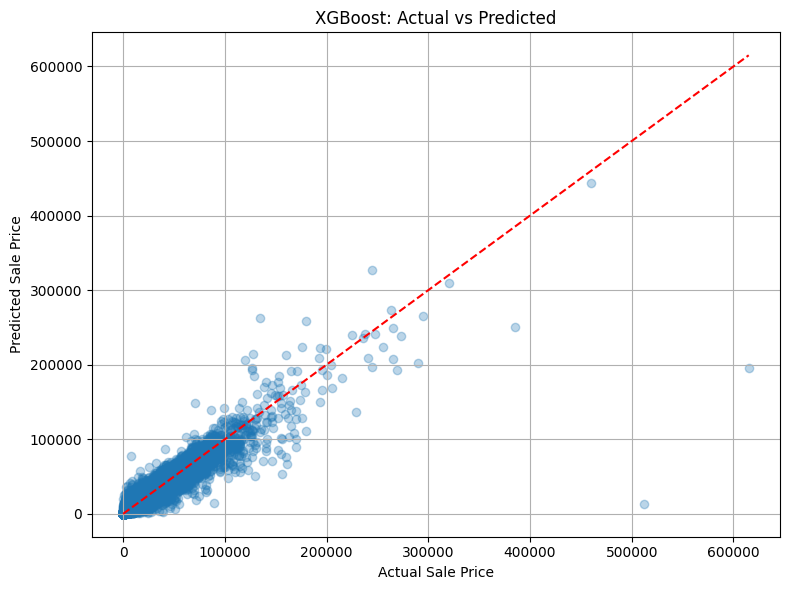

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, xgb_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('XGBoost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import shap
import matplotlib.pyplot as plt

In [ ]:
import shap
import scipy.sparse as sp

# ---- after you've fit: xgb_pipeline_ttr.fit(X_train, y_train) ---- 

# 1) unwrap the fitted inner pipeline
inner = xgb_pipeline_ttr.regressor_                  # this is your Pipeline(preproc -> xgb)
preproc = inner.named_steps['preproc']
fitted_xgb = inner.named_steps['xgb']

# 2) transform X_test using the fitted preprocessor
X_test_trans = preproc.transform(X_test)

# SHAP prefers dense arrays for many explainers; make dense if needed
if sp.issparse(X_test_trans):
    X_test_trans = X_test_trans.toarray()

# 3) feature names that exactly match transformed columns
feature_names = preproc.get_feature_names_out()

# 4) SHAP TreeExplainer on the trained XGBRegressor
explainer = shap.TreeExplainer(fitted_xgb)
shap_values = explainer.shap_values(X_test_trans)

# 5) summary plot
shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names)

In [ ]:
import scipy.sparse as sp

# grab the first row of your transformed test set
first_row_sparse = X_test_trans[0]

# convert to a 1-D numpy array
if sp.issparse(first_row_sparse):
    first_row = first_row_sparse.toarray().flatten()
else:
    first_row = first_row_sparse

# now do the force plot
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    first_row,
    feature_names=feature_names
)

CatBoost

In [149]:
import optuna
import numpy as np
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.base import clone
import os

# ======= TUNABLE FAST MODE KNOBS =======
TIME_BUDGET_SECONDS = None     # e.g., 600 for 10 minutes
N_TRIALS = 50                 # 20–50 for quick tests; 100+ for better tuning
K_FOLDS = 3                    # smaller k = faster
# =======================================

optuna.logging.set_verbosity(optuna.logging.INFO)


def _fmt_params(d):
    out = {}
    for k, v in d.items():
        out[k] = float(f"{v:.5g}") if isinstance(v, float) else v
    return out


def objective(trial):
    print(f"[trial {trial.number}] starting...", flush=True)

    # 1️⃣ choose bootstrap type first
    bootstrap_type = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])

    # 2️⃣ common parameters
    params = dict(
        loss_function="RMSE",
        eval_metric="RMSE",
        depth=trial.suggest_int("depth", 6, 10),
        learning_rate=trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
        rsm=trial.suggest_float("rsm", 0.6, 0.95),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 3.0, 15.0),
        random_strength=trial.suggest_float("random_strength", 0.0, 1.5),
        min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 16, 256),
        iterations=trial.suggest_int("iterations", 1000, 5000),
        od_type="Iter",
        od_wait=200,
        use_best_model=True,
        one_hot_max_size=16,
        random_state=42,
        verbose=False,
        bootstrap_type=bootstrap_type,
        thread_count=os.cpu_count() // 2,
    )

    # 3️⃣ add mode-specific parameter
    if bootstrap_type == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif bootstrap_type == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)

    print(f"  [trial {trial.number}] params: {_fmt_params(params)}", flush=True)
    trial.set_user_attr("printed_params", _fmt_params(params))

    model = CatBoostRegressor(**params)

    pipe = Pipeline([
        ('preproc', preprocessor),
        ('cat', model)
    ])

    # 4️⃣ cross-validation
    cv = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    scores = []

    for fold, (tr_idx, val_idx) in enumerate(cv.split(X_train), start=1):
        X_tr = X_train.iloc[tr_idx]
        y_tr = y_train.iloc[tr_idx]
        X_val = X_train.iloc[val_idx]
        y_val = y_train.iloc[val_idx]

        fold_pipe = clone(pipe)
        fold_pipe.fit(X_tr, y_tr)
        y_pred = fold_pipe.predict(X_val)
        score = r2_score(y_val, y_pred)
        scores.append(score)

        mean_so_far = float(np.mean(scores))
        print(f"    Fold {fold}/{K_FOLDS}: R²={score:.4f} | mean={mean_so_far:.4f}", flush=True)

        trial.report(mean_so_far, step=fold)
        if trial.should_prune():
            print(f"  [trial {trial.number}] PRUNED at fold {fold}", flush=True)
            raise optuna.exceptions.TrialPruned()

    mean_score = float(np.mean(scores))
    print(f"[trial {trial.number}] mean CV R²={mean_score:.4f}", flush=True)
    return mean_score


def print_callback(study, trial):
    print(
        f"Trial {trial.number} finished with value={trial.value:.4f} "
        f"and params={_fmt_params(trial.params)}. Best so far: {study.best_value:.4f}",
        flush=True
    )


# --- pruning and sampling ---
sampler = optuna.samplers.TPESampler(
    seed=42,
    n_startup_trials=10,
    n_ei_candidates=12,
    multivariate=True,
    group=True,
)
pruner = optuna.pruners.SuccessiveHalvingPruner(
    min_resource=1,
    reduction_factor=3,
    min_early_stopping_rate=0,
)

# 5️⃣ create and optimize
study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)

opt_kwargs = dict(
    n_trials=N_TRIALS if TIME_BUDGET_SECONDS is None else None,
    timeout=TIME_BUDGET_SECONDS,
    n_jobs=1,
    callbacks=[print_callback],
    show_progress_bar=True
)

study.optimize(objective, **opt_kwargs)

print("\n--- OPTIMIZATION COMPLETE ---")
print("Best CV R²: {:.4f}".format(study.best_value))
print("Best params:", _fmt_params(study.best_params), flush=True)

[I 2025-11-05 15:18:09,817] A new study created in memory with name: no-name-28898aee-ef29-48e8-84db-22ba0eba531c
  0%|          | 0/100 [00:00<?, ?it/s]

[trial 0] starting...
  [trial 0] params: {'loss_function': 'RMSE', 'eval_metric': 'RMSE', 'depth': 8, 'learning_rate': 0.028645, 'rsm': 0.6546, 'l2_leaf_reg': 3.697, 'random_strength': 1.2993, 'min_data_in_leaf': 160, 'iterations': 3832, 'od_type': 'Iter', 'od_wait': 200, 'use_best_model': True, 'one_hot_max_size': 16, 'random_state': 42, 'verbose': False, 'bootstrap_type': 'Bernoulli', 'thread_count': 8, 'subsample': 0.51029}


  0%|          | 0/100 [00:17<?, ?it/s]


[W 2025-11-05 15:18:27,660] Trial 0 failed with parameters: {'bootstrap_type': 'Bernoulli', 'depth': 8, 'learning_rate': 0.0286449874364605, 'rsm': 0.6545980821176709, 'l2_leaf_reg': 3.6970033460183935, 'random_strength': 1.2992642186624028, 'min_data_in_leaf': 160, 'iterations': 3832, 'subsample': 0.5102922471479012} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\ChenChen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ChenChen\AppData\Local\Temp\ipykernel_21564\568173342.py", line 80, in objective
    fold_pipe.fit(X_tr, y_tr)
    ~~~~~~~~~~~~~^^^^^^^^^^^^
  File "C:\Users\ChenChen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\base.py", line 1389, in wrapper
    retu

KeyboardInterrupt: 

In [ ]:
from catboost import CatBoostRegressor
catboost_model = CatBoostRegressor(
    iterations= 300,
    learning_rate= 0.11171350069200518,
    depth= int(10.0),
    rsm= 0.82687355368143,
    l2_leaf_reg= 0.2101862436094146,
    random_strength = 1.4638338855657618,
    min_data_in_leaf = 6,
    subsample = 0.9968309468360523,
    bootstrap_type = 'Bernoulli',
    loss_function='RMSE',
    verbose=0,
    random_state=42,
    border_count=128,
    
)

In [ ]:
from sklearn.pipeline import Pipeline

catboost_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('catboost', catboost_model)
])

catboost_pipeline_ttr = with_log_target(catboost_pipeline)

In [ ]:
# Fit the pipeline
catboost_pipeline_ttr.fit(X_train, y_train)

# Predict on test data
catboost_preds = catboost_pipeline_ttr.predict(X_test)
catboost_preds_external = catboost_pipeline_ttr.predict(X_external)

In [ ]:
catboost_r2 = r2_score(y_test, catboost_preds)
catboost_mae = mean_absolute_error(y_test, catboost_preds)
catboost_mse = mean_squared_error(y_test, catboost_preds)
catboost_rmse = np.sqrt(catboost_mse)
catboost_mape = mean_absolute_percentage_error(y_test, catboost_preds)

# Display results
print("📊 catboost Regression Evaluation Metrics")
print(f"R² Score  : {catboost_r2:.4f}")
print(f"MAE       : {catboost_mae:.2f}")
print(f"MSE       : {catboost_mse:.2f}")
print(f"RMSE      : {catboost_rmse:.2f}")
print(f"MAPE      : {catboost_mape:.2%}")

📊 catboost Regression Evaluation Metrics
R² Score  : 0.9154
MAE       : 1817.99
MSE       : 11821770.38
RMSE      : 3438.28
MAPE      : 30.13%


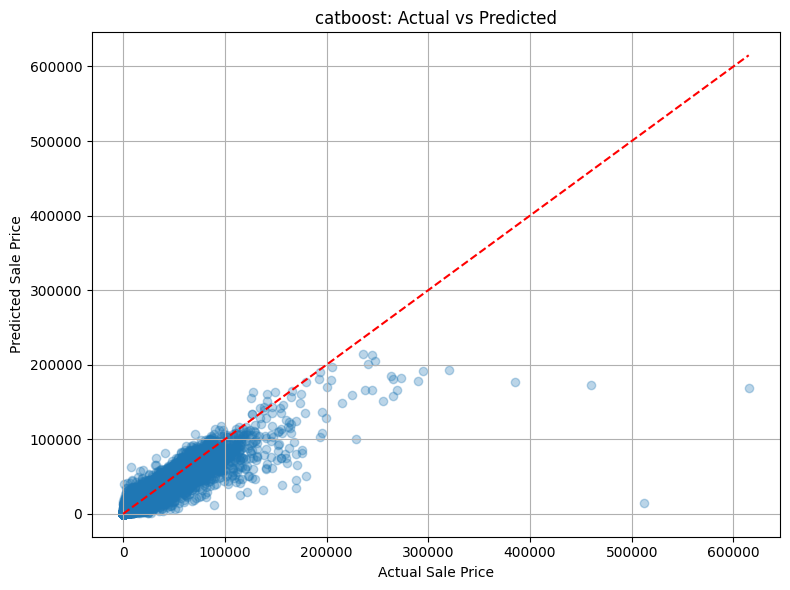

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, catboost_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('catboost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

CatBoost Native Handling

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
categorical_feats = list(pd.Index(categorical_feats).unique())
numeric_feats     = list(pd.Index(numeric_feats).unique())
all_feats         = categorical_feats + numeric_feats  # order matters for indices

In [ ]:
X_train_all    = X_train[all_feats].copy()
X_test_all     = X_test[all_feats].copy()
X_external_all = X_external[all_feats].copy()

In [ ]:
# 2) Fill/convert categorical columns on ALL splits
def prep_cats(df, cat_cols):
    # Fill NaN, then cast to string/object (CatBoost wants strings/ints, not floats/NaN)
    df[cat_cols] = df[cat_cols].fillna('Unknown').astype(str)
    return df

X_train_all    = prep_cats(X_train_all,    categorical_feats)
X_test_all     = prep_cats(X_test_all,     categorical_feats)
X_external_all = prep_cats(X_external_all, categorical_feats)

In [ ]:
# 3) Cat feature indices must match the columns you pass into Pool
cat_feature_indices = [all_feats.index(c) for c in categorical_feats]

# 4) Train on log-target and predict
y_train_log = np.log1p(y_train)

train_pool = Pool(X_train_all, y_train_log, cat_features=cat_feature_indices)
test_pool  = Pool(X_test_all,  cat_features=cat_feature_indices)
ext_pool   = Pool(X_external_all, cat_features=cat_feature_indices)

In [ ]:
cat_model = CatBoostRegressor(
    iterations= 300,
    learning_rate= 0.08429942269815302,
    depth= int(10.0),
    rsm= 0.7635618390664082,
    l2_leaf_reg= 0.7045490097809968,
    random_strength = 1.3020316063431894,
    min_data_in_leaf = 1,
    subsample = 0.9867394847157086,
    bootstrap_type = 'Bernoulli',
    loss_function='RMSE',
    verbose=0,
    random_state=42,
)

cat_model.fit(train_pool)

In [ ]:
cat_log_preds          = cat_model.predict(test_pool)
cat_preds              = np.expm1(cat_log_preds)

cat_log_preds_external = cat_model.predict(ext_pool)
cat_preds_external     = np.expm1(cat_log_preds_external)

In [ ]:
cat_r2 = r2_score(y_test, cat_preds)
cat_mae = mean_absolute_error(y_test, cat_preds)
cat_mse = mean_squared_error(y_test, cat_preds)
cat_rmse = np.sqrt(cat_mse)
cat_mape = mean_absolute_percentage_error(y_test, cat_preds)

# Display results
print("📊 catboost Regression Evaluation Metrics")
print(f"R² Score  : {cat_r2:.4f}")
print(f"MAE       : {cat_mae:.2f}")
print(f"MSE       : {cat_mse:.2f}")
print(f"RMSE      : {cat_rmse:.2f}")
print(f"MAPE      : {cat_mape:.2%}")

📊 catboost Regression Evaluation Metrics
R² Score  : 0.9290
MAE       : 1660.51
MSE       : 9919359.11
RMSE      : 3149.50
MAPE      : 28.37%


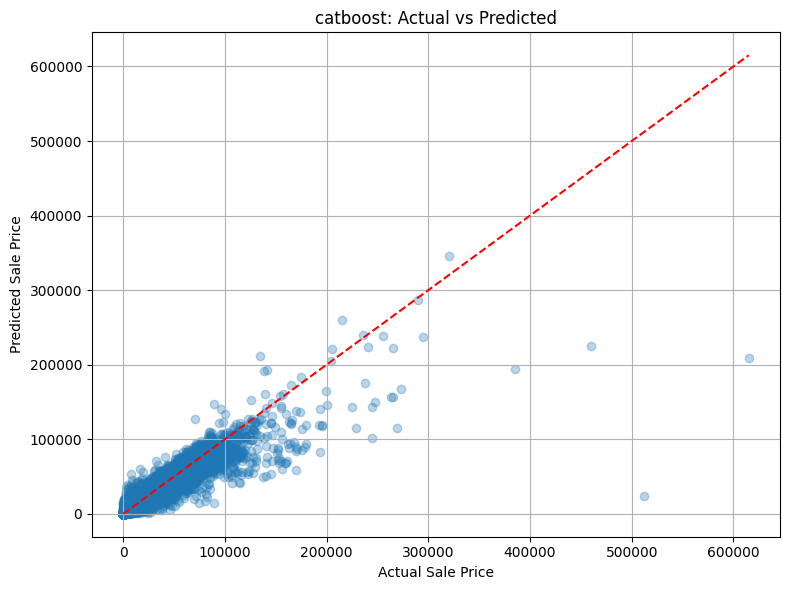

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, cat_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('catboost: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

Model Combination

In [ ]:
import optuna
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
# Define the base models with fixed parameters
catboost_model = CatBoostRegressor(
    iterations= 300,
    learning_rate= 0.08429942269815302,
    depth= int(10.0),
    rsm= 0.7635618390664082,
    l2_leaf_reg= 0.7045490097809968,
    random_strength = 1.3020316063431894,
    min_data_in_leaf = 1,
    subsample = 0.9867394847157086,
    bootstrap_type = 'Bernoulli',
    loss_function='RMSE',
    verbose=0,
    random_state=42,
)

xgb_model = XGBRegressor(
    # fixed hyperparameters from BayesOpt:
    max_depth=10,
    learning_rate=0.21245910053249895,
    subsample=0.8023816022011749,
    colsample_bytree=0.538889024654892,
    gamma=2.1537703839033284,
    min_child_weight=3,
    reg_alpha=0.914666448962566,
    reg_lambda=4.265359935084676,
    # keep the rest as before:
    objective='reg:squarederror',
    eval_metric='rmse',
    use_label_encoder=False,
    random_state=0,
    n_estimators=200,
    n_jobs=-1
)

In [ ]:
# from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Meta model: scale sparse features safely (with_mean=False),
# then use a simple linear model that can extrapolate.
meta = make_pipeline(
    StandardScaler(with_mean=False),  # handles sparse OHE output without densifying
    Ridge(alpha=1.0, random_state=42)
)

stack = StackingRegressor(
    estimators=[('Cat', catboost_model), ('xgb', xgb_model)],
    final_estimator=meta,
    passthrough=True,     # keep raw (preprocessed) features at meta layer
    cv=5                  # out-of-fold preds for meta (default=5, but make explicit)
)

stacking_pipeline = Pipeline([
    ('preproc', preprocessor),  # produces a (mostly) sparse matrix
    ('stack',   stack)
])

stacking_pipeline_ttr = with_log_target(stacking_pipeline)


In [ ]:
# 5) Fit & evaluate
stacking_pipeline_ttr.fit(X_train, y_train)
y_pred = stacking_pipeline_ttr.predict(X_test)
y_pred_external = stacking_pipeline_ttr.predict(X_external)

In [ ]:
y_r2 = r2_score(y_test, y_pred)
y_mae = mean_absolute_error(y_test, y_pred)
y_mse = mean_squared_error(y_test, y_pred)
y_rmse = np.sqrt(y_mse)
y_mape = mean_absolute_percentage_error(y_test, y_pred)

# Display results
print("📊 stack Regression Evaluation Metrics")
print(f"R² Score  : {y_r2:.4f}")
print(f"MAE       : {y_mae:.2f}")
print(f"MSE       : {y_mse:.2f}")
print(f"RMSE      : {y_rmse:.2f}")
print(f"MAPE      : {y_mape:.2%}")

📊 stack Regression Evaluation Metrics
R² Score  : 0.9378
MAE       : 1589.24
MSE       : 8695519.35
RMSE      : 2948.82
MAPE      : 27.92%


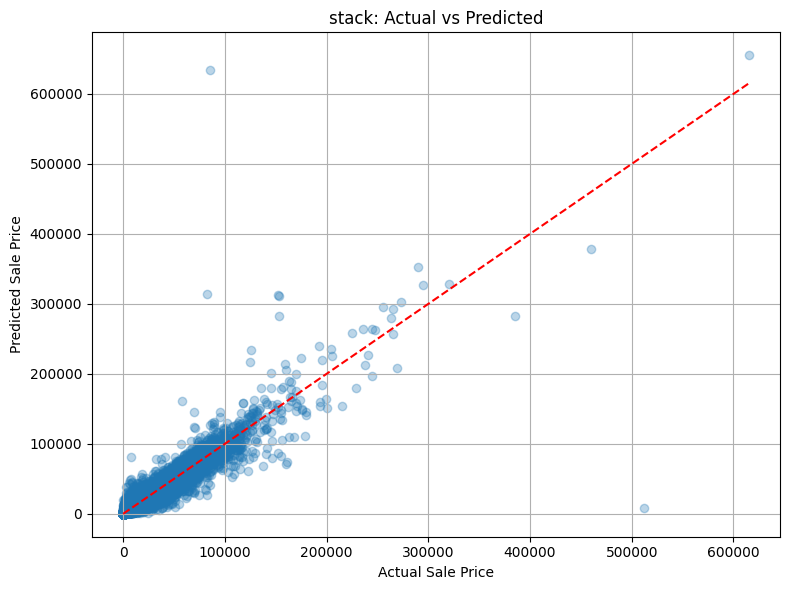

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('stack: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 0) Use your current test set as a validation fold for blending/calibration
X_valid, y_valid = X_test, y_test
p_stack_valid = y_pred                    # already computed by your log-target stack

# 1) Train a raw-target robust model (pick LightGBM if available; else fallback to sklearn HGB)
try:
    from lightgbm import LGBMRegressor
    raw_model = Pipeline([
        ('preproc', preprocessor),
        ('lgb', LGBMRegressor(
            objective='huber',          # robust to outliers; good on $ scale
            n_estimators=5000,
            learning_rate=0.03,
            num_leaves=63,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42
        ))
    ])
except Exception:
    # Fallback if LightGBM isn't installed
    from sklearn.ensemble import HistGradientBoostingRegressor
    raw_model = Pipeline([
        ('preproc', preprocessor),
        ('hgb', HistGradientBoostingRegressor(
            loss='absolute_error',      # MAE/median-ish; robust on raw target
            max_iter=800,
            learning_rate=0.05,
            random_state=42
        ))
    ])

In [ ]:
# Fit on RAW target (no log)
raw_model.fit(X_train, y_train)
p_raw_valid = raw_model.predict(X_valid)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.288789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16501
[LightGBM] [Info] Number of data points in the train set: 3167315, number of used features: 7297
[LightGBM] [Info] Start training from score 10760.664923


In [ ]:
# 2) Convex blend (non-negative least squares) to reduce variance & fix upper tail
from scipy.optimize import nnls
import numpy as np

P = np.column_stack([p_stack_valid, p_raw_valid])
w, _ = nnls(P, y_valid)           # non-negative weights
w = w / w.sum()                   # normalize to sum to 1
p_blend_valid = P @ w
print(f"Blend weights -> stack_log: {w[0]:.3f} | raw_robust: {w[1]:.3f}")

Blend weights -> stack_log: 0.951 | raw_robust: 0.049


In [ ]:
# 3) Monotone calibration (isotonic) — stretches the top end without breaking order
from sklearn.isotonic import IsotonicRegression
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_blend_valid, y_valid)
p_blend_cal_valid = iso.transform(p_blend_valid)

In [ ]:
def report(name, y_true, y_hat):
    y_true = np.asarray(y_true, dtype=float).ravel()
    y_hat  = np.asarray(y_hat,  dtype=float).ravel()
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))  # no 'squared' kw in older sklearn
    print(f"{name:22s}  R2={r2_score(y_true,y_hat):.4f}  "
          f"MAE={mean_absolute_error(y_true,y_hat):,.0f}  "
          f"RMSE={rmse:,.0f}")

report("Stack (log)        ", y_valid, p_stack_valid)
report("Raw robust         ", y_valid, p_raw_valid)
report("Blend              ", y_valid, p_blend_valid)
report("Blend + Isotonic   ", y_valid, p_blend_cal_valid)

Stack (log)             R2=0.9378  MAE=1,589  RMSE=2,949
Raw robust              R2=0.0130  MAE=8,134  RMSE=11,746
Blend                   R2=0.9384  MAE=1,611  RMSE=2,934
Blend + Isotonic        R2=0.9459  MAE=1,564  RMSE=2,751


In [ ]:
# ==== SAFE REFIT + EXTERNAL PREDICTIONS (Windows-friendly) ====

# 0) Make sure you still have these from earlier:
#    - preprocessor
#    - stacking_pipeline (the StackingRegressor inside)
#    - raw_model (LightGBM/HGB pipeline you defined)
#    - X_train, y_train, X_test, y_test, X_external
#    - w, p_blend_valid, y_valid, iso  (from the blend/calibration step)

# A) Ensure the stack does not try to spawn processes (avoid _posixsubprocess on Windows)
try:
    stacking_pipeline.named_steps['stack'].set_params(n_jobs=1)
except Exception:
    pass  # older sklearn may not have n_jobs on StackingRegressor; it's fine

# B) Fit fresh, explicit instances (don’t reuse possibly reset objects)
stack_log_fitted = with_log_target(stacking_pipeline)
stack_log_fitted.fit(X_train, y_train)     # log-target fit

raw_fitted = raw_model
raw_fitted.fit(X_train, y_train)           # raw-target fit

# C) Make sure isotonic calibrator is fitted (uses your validation fold)
from sklearn.isotonic import IsotonicRegression
try:
    _ = iso.transform([0.0])               # will fail if iso isn't fitted
except Exception:
    iso = IsotonicRegression(out_of_bounds='clip')
    # Recompute blended valid preds if needed
    try:
        P_valid = np.column_stack([p_stack_valid, p_raw_valid])
    except NameError:
        # regenerate validation predictions if this is a fresh kernel
        p_stack_valid = stack_log_fitted.predict(X_test)
        p_raw_valid   = raw_fitted.predict(X_test)
        P_valid       = np.column_stack([p_stack_valid, p_raw_valid])
        # re-derive weights if missing
        try:
            w
        except NameError:
            from scipy.optimize import nnls
            w, _ = nnls(P_valid, y_test.to_numpy())
            w = w / w.sum()
    p_blend_valid = P_valid @ w
    iso.fit(p_blend_valid, y_test.to_numpy())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.277811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16501
[LightGBM] [Info] Number of data points in the train set: 3167315, number of used features: 7297
[LightGBM] [Info] Start training from score 10760.664923


In [ ]:
# D) External predictions with SAME weights & calibrator
p_stack_ext = stack_log_fitted.predict(X_external)
p_raw_ext   = raw_fitted.predict(X_external)
P_ext       = np.column_stack([p_stack_ext, p_raw_ext])
p_blend_ext = P_ext @ w
p_blend_cal_ext = iso.transform(p_blend_ext)

Visualize the actual prices and Predicted prices

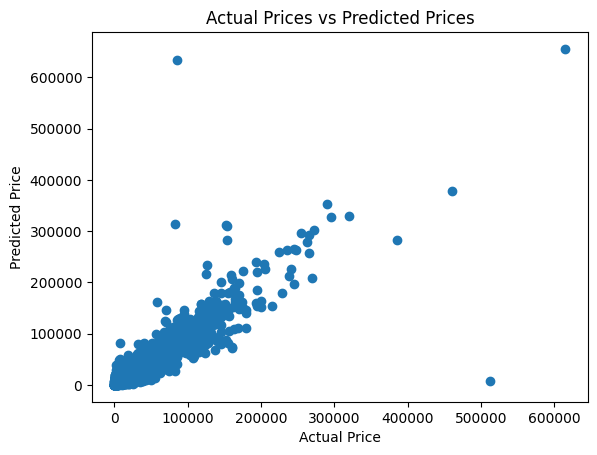

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Prices vs Predicted Prices")
plt.show()

Final Model Evaluation

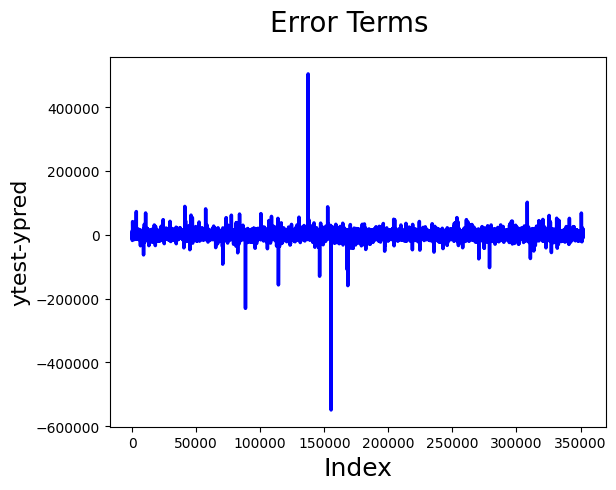

In [ ]:
# Error terms
c = [i for i in range(len(y_pred))]
fig = plt.figure()
plt.plot(c,y_test-y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label
plt.show()

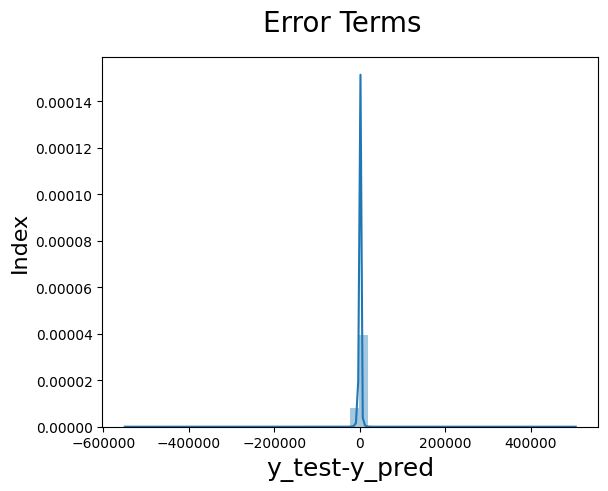

In [ ]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label
plt.show()

Export the Predictions

In [ ]:
# 1) Extract the true y values for X_external
y_external = cars_test['VRSALEAMT']

# 2) Compute R² for each model
r2_xgb      = r2_score(y_external, xgb_predictions_external)
r2_catboost = r2_score(y_external, catboost_preds_external)
r2_Cat_Native = r2_score(y_external, cat_preds_external)
r2_stack    = r2_score(y_external, y_pred_external)
r2_Blend    = r2_score(y_external, p_blend_cal_ext)

# 3) Print results
print(f"XGBoost external R²:      {r2_xgb:.4f}")
print(f"CatBoost external R²:     {r2_catboost:.4f}")
print(f"CatBoost Native R²:     {r2_Cat_Native:.4f}")
print(f"Stacked model external R²:{r2_stack:.4f}")
print(f"Blended model external R²:{r2_Blend:.4f}")

XGBoost external R²:      0.8982
CatBoost external R²:     0.8827
CatBoost Native R²:     0.9406
Stacked model external R²:0.9090
Blended model external R²:0.9151


In [ ]:
# # Create a DataFrame with the original prices and the predicted sales prices
# result_df = pd.DataFrame({
#     'SoldPrice': y_test,  # Original prices from y_test
#     'XGB_Predictions': xgb_predictions,
#     'RF_Predictions': rf_predictions,
#     'Stacked_Predictions': y_pred
# })
1
result_df = pd.DataFrame({
    'XGB_Predictions': xgb_predictions_external,
    'CatBoost_Predictions': catboost_preds_external,
    'CatBoost_Native_Predictions': cat_preds_external,
    'Stacked_Predictions': y_pred_external,
    'Blended_Calibrated': p_blend_cal_ext
})

final_df = pd.concat([cars_test_original.reset_index(drop=True), result_df.reset_index(drop=True)], axis=1)

# Export the DataFrame to a CSV file
final_df.to_excel('AAA Test.xlsx', sheet_name='sheet 1', index=False)